#### Imports

In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from minisom import MiniSom

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC


#### Fonctions utilitaires pour parcourir les images

In [2]:
common_path = "./chest_Xray"
images_files = os.listdir(common_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    for subfolder in subfolders:
        for category in categories:
            # pour avoir tous les chemins des 6 dossiers
            folder_path = os.path.join(common_path, subfolder, category)
            # liste de toutes les images
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            #récupération de toutes les (ou des 'limit_size' premières) images du dossier.
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path,file_name)
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                img_callback(img, category)
                
                
def display_imgs(imgs, titles = [], plot_size = (1,1), figsize = (10,8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index) 
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [3]:
def img_is_in_ratio(img, min_ratio = 1, max_ratio = 1.5):
    height, width = img.shape
    ratio = width / height
    if min_ratio <= ratio <= max_ratio:
        return True
    else:
        return False

In [4]:
grey_scale_limit = 10

def img_has_atleast_black_pixels(img, threshold = 5):
    height, width = img.shape
    percent = (np.sum(img <= grey_scale_limit)*100)/(width*height)
    return percent >= threshold

In [5]:
all_images = []
all_categories = []

max_ratio_threshold = 1.6
all_images_index_ratio = []

min_black_pixels_threshold = 5
all_images_indexes_black_pixels = []

all_images_index_ratio_and_black_pixels = []

datasetX = []
datasetY = []

image_size = (800, 800)

def load_datasets(img, category):
    new_img = cv2.resize(img, image_size)
    all_images.append(new_img)
    all_categories.append(category)

    if img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold):
        all_images_indexes_black_pixels.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold) and img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio_and_black_pixels.append(len(all_images)-1)

    
browse_imgs(load_datasets)

def use_all_dataset():
    global datasetX, datasetY
    datasetX = np.array(all_images)
    datasetY = np.array(all_categories)
 
def use_ratio_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio])

def use_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_indexes_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_indexes_black_pixels])

def use_ratio_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio_and_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio_and_black_pixels])

use_all_dataset()
print("Dataset all shape : ", datasetX.shape)
use_black_pixel_dataset()
print("Dataset bp shape : ", datasetX.shape)
use_ratio_dataset()
print("Dataset ration shape : ", datasetX.shape)
use_ratio_black_pixel_dataset()
print("Dataset bp+ratio shape : ", datasetX.shape)


KeyboardInterrupt: 

#### Cross validation

In [11]:
def cross_val(model, load_dataset_function, scoring, nb_folds=3):
    load_dataset_function()
    res = cross_validate(model, datasetX, datasetY, cv=nb_folds, scoring=scoring, error_score="raise", return_train_score=True)
    res.pop("fit_time")
    res.pop("score_time")
    return res
    

def fit_and_score_each_dataset(model, scoring):
    res = {}
    
    res["all"] = (cross_val(model, use_all_dataset, scoring))
    # res["ratio"] = (cross_val(model, use_ratio_dataset, scoring))
    # res["black_pixel"] = (cross_val(model, use_black_pixel_dataset, scoring))
    # res["ratio_black_pixel"] = (cross_val(model, use_ratio_black_pixel_dataset, scoring))
    
    return res

#### Resize and Flatten Transformers

In [7]:
class ResizeImageTransformer():
    def __init__(self, size):
        self.size = size
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = np.array([cv2.resize(img, self.size) for img in X])
        return X

class FlattenTransformer():    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.reshape(len(X), -1)
        return X

#### Définition des différentes metrics

In [12]:
general_scoring = {
    "recall": make_scorer(recall_score, pos_label="PNEUMONIA"),
    "precision": make_scorer(precision_score, pos_label="PNEUMONIA"),
    "f1": make_scorer(f1_score, pos_label="PNEUMONIA")
}

#### SVC

In [13]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    SVC(kernel='linear', C=1.0, random_state=42, verbose=True)
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

[LibSVM]

[LibSVM]recall :  0.9736238532110092
precision :  0.9582392776523702
f1score :  0.9658703071672355


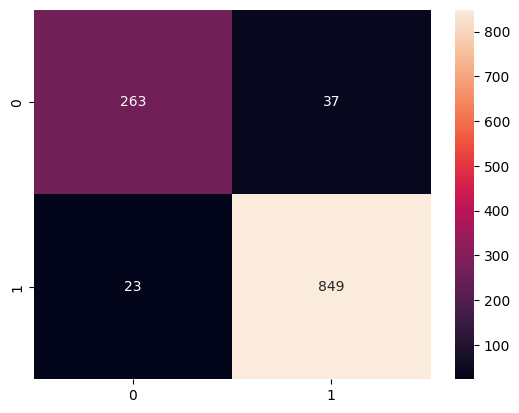

In [10]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
model.fit(trainx, trainy)

y_pred = model.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [19]:
model.get_params()

{'memory': None,
 'steps': [('resizeimagetransformer',
   <__main__.ResizeImageTransformer at 0x13d2b9e2660>),
  ('flattentransformer', <__main__.FlattenTransformer at 0x13d2bb75010>),
  ('svc', SVC(kernel='linear', random_state=42, verbose=True))],
 'verbose': False,
 'resizeimagetransformer': <__main__.ResizeImageTransformer at 0x13d2b9e2660>,
 'flattentransformer': <__main__.FlattenTransformer at 0x13d2bb75010>,
 'svc': SVC(kernel='linear', random_state=42, verbose=True),
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'linear',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': 42,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': True}

In [1]:
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto'],
}

grid_search = GridSearchCV(model, param_grid, cv=3, verbose=3)
grid_search.fit(trainx, trainy)

NameError: name 'GridSearchCV' is not defined

#### Dummy Classifier

In [9]:
model = make_pipeline(
    FlattenTransformer(),
    DummyClassifier(strategy="most_frequent")
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

,all,ratio,black_pixel,ratio_black_pixel
test_recall,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
train_recall,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
test_precision,"[0.7295221843003413, 0.7292912040990607, 0.729...","[0.6617812852311161, 0.6613995485327314, 0.661...","[0.5943396226415094, 0.5943396226415094, 0.594...","[0.5109780439121756, 0.5109780439121756, 0.512..."
train_precision,"[0.7297181895815542, 0.7297758804695837, 0.729...","[0.6616817155756207, 0.6617771509167842, 0.661...","[0.5940204563335956, 0.5940204563335956, 0.594...","[0.511744127936032, 0.511744127936032, 0.51148..."
test_f1,"[0.8436112481499753, 0.8434567901234568, 0.843...","[0.7964721845318861, 0.7961956521739131, 0.796...","[0.7455621301775148, 0.7455621301775148, 0.745...","[0.6763540290620872, 0.6763540290620872, 0.677..."
train_f1,"[0.8437422858553444, 0.8437808489634748, 0.843...","[0.7964000679232467, 0.7964691902902733, 0.796...","[0.7453109575518263, 0.7453109575518263, 0.745...","[0.6770247933884298, 0.6770247933884298, 0.676..."


recall :  1.0
precision :  0.7440273037542662
f1score :  0.8532289628180039


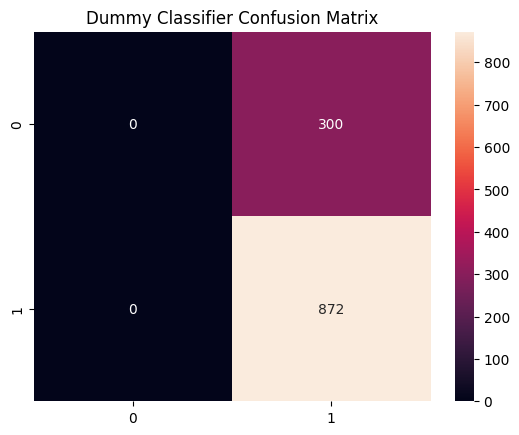

In [10]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
model.fit(trainx, trainy)

y_pred = model.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Dummy Classifier Confusion Matrix")
plt.show()

#### KNeighborsClassifier

In [20]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=11, weights='uniform', algorithm='auto')
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

,all,ratio,black_pixel,ratio_black_pixel
test_recall,"[0.9836257309941521, 0.9836065573770492, 0.981...","[0.969335604770017, 0.9641638225255973, 0.9641...","[0.9576719576719577, 0.9603174603174603, 0.962...","[0.9140625, 0.90625, 0.9140625, 0.8671875, 0.9..."
train_recall,"[0.9888823873610298, 0.9880081895291021, 0.986...","[0.9752665245202559, 0.9782608695652174, 0.973...","[0.971523178807947, 0.9688741721854305, 0.9635...","[0.9208984375, 0.9345703125, 0.923828125, 0.92..."
test_precision,"[0.908207343412527, 0.9180327868852459, 0.9178...","[0.9104, 0.9216965742251223, 0.911290322580645...","[0.8743961352657005, 0.8832116788321168, 0.926...","[0.9105058365758755, 0.90625, 0.92490118577075..."
train_precision,"[0.9154929577464789, 0.9164405860010851, 0.913...","[0.9100676482292082, 0.9143426294820717, 0.916...","[0.8758208955223881, 0.875, 0.886654478976234,...","[0.890462700661001, 0.8994360902255639, 0.9087..."
test_f1,"[0.9444132509825941, 0.9496890898812889, 0.948...","[0.9389438943894389, 0.9424520433694745, 0.936...","[0.9141414141414141, 0.9201520912547528, 0.944...","[0.9122807017543859, 0.90625, 0.91944990176817..."
train_f1,"[0.9507735583684951, 0.9508796622097114, 0.948...","[0.9415397282832442, 0.9452224052718287, 0.944...","[0.921193092621664, 0.9195474544311754, 0.9235...","[0.9054248679788767, 0.9166666666666666, 0.916..."


recall :  0.9839449541284404
precision :  0.9098621420996819
f1score :  0.9454545454545454


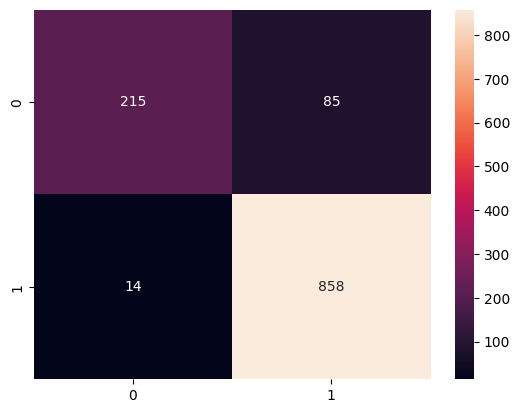

In [28]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
model.fit(trainx, trainy)

y_pred = model.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

# ou sns.heatmap(cm, annot=True, fmt="d")
# plt.show()

In [34]:
image_path = "./chest_Xray/train/PNEUMONIA/person1_bacteria_1.jpeg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
weights = model.predict_proba(image)

In [37]:
image_path = "./chest_Xray/train/PNEUMONIA/person1_bacteria_1.jpeg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = image.reshape(1, image.shape[0], image.shape[1], 1)  # Reshape image to have 4 dimensions
weights = model.predict_proba(image)
heatmap = weights[0, 1]  # Use the predicted probability for the class of interest
heatmap = np.full(image.shape[1:3], heatmap)  # Create a heatmap with the same shape as the original image

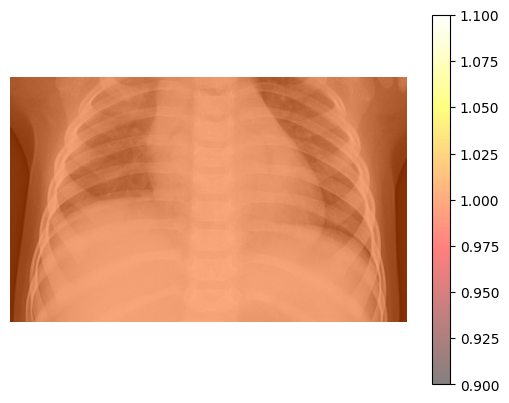

In [39]:
image = np.squeeze(image)
heatmap = np.squeeze(heatmap)

plt.imshow(image, cmap='gray')
plt.imshow(heatmap, cmap='hot', alpha=0.5)  # Display the heatmap with a transparent overlay
plt.colorbar()  # Add a color bar for the heatmap
plt.axis('off')  # Remove the axes
plt.show()

In [29]:
# Initialize and train a SOM
# The dimensions (x, y) of the SOM should be chosen based on your specific needs
x, y = 20, 20
# Ensure trainx is a 3D array of shape (n, 800, 800)
assert len(trainx.shape) == 3 and trainx.shape[1] == trainx.shape[2] == 800

# Flatten the images
trainx_flattened = trainx.reshape(trainx.shape[0], -1)

# Initialize and train a SOM
som = MiniSom(x, y, trainx_flattened.shape[1], sigma=0.5, learning_rate=0.5)
som.train_random(trainx_flattened, 100)

# Use the SOM to visualize the results
# Each neuron in the SOM represents a cluster
# The distance between the neurons represents the similarity between the clusters
plt.figure(figsize=(10, 10))
for (x, y) in som.win_map(trainx_flattened).keys():
    plt.text(x, y, '.', color='k')
plt.xlim([0, x])
plt.ylim([0, y])
plt.show()

KeyboardInterrupt: 

<Figure size 1000x1000 with 0 Axes>

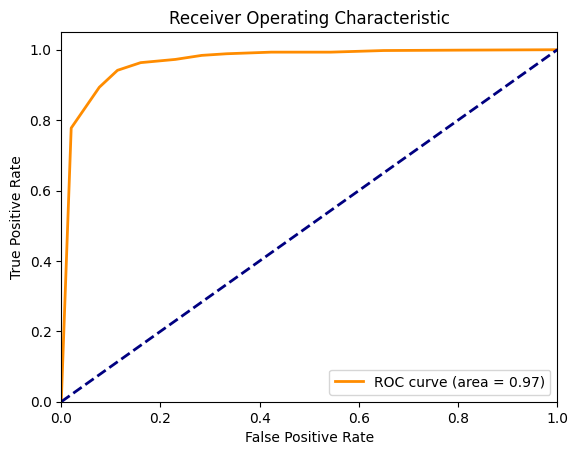

In [24]:
from sklearn.metrics import roc_curve, auc

# ... your existing code ...

# Compute the probabilities of the positive class
y_pred_proba = model.predict_proba(testx)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(testy, y_pred_proba, pos_label="PNEUMONIA")

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def display_distribution():
    test = (np.count_nonzero(testy == "NORMAL"), np.count_nonzero(testy == "PNEUMONIA"))
    train = (np.count_nonzero(trainy == "NORMAL"), np.count_nonzero(trainy == "PNEUMONIA"))
    
    # Plot the distribution graphs
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].bar(["NORMAL", "PNEUMONIA"], train)
    ax[0].set_title("Train Distribution")
    ax[1].bar(["NORMAL", "PNEUMONIA"], test)
    ax[1].set_title("Test Distribution")
    plt.show()

display_distribution()

#### Model Random Forest

In [15]:
# Model random forest
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    RandomForestClassifier(n_estimators=100, random_state=0)
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

,all,ratio,black_pixel,ratio_black_pixel
test_recall,"[0.960233918128655, 0.9742388758782201, 0.9683...","[0.9352640545144804, 0.962457337883959, 0.9488...","[0.9417989417989417, 0.9523809523809523, 0.957...","[0.91796875, 0.9140625, 0.9296875, 0.9140625, ..."
train_recall,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
test_precision,"[0.960233918128655, 0.9776733254994124, 0.9549...","[0.9336734693877551, 0.9740932642487047, 0.955...","[0.9368421052631579, 0.9424083769633508, 0.947...","[0.9215686274509803, 0.9551020408163265, 0.929..."
train_precision,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
test_f1,"[0.960233918128655, 0.9759530791788856, 0.9616...","[0.934468085106383, 0.9682403433476395, 0.9520...","[0.9393139841688655, 0.9473684210526315, 0.952...","[0.9197651663405088, 0.9341317365269461, 0.929..."
train_f1,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"


In [16]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)

model.fit(trainx, trainy)

y_pred = model.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

recall :  0.9678899082568807
precision :  0.9472502805836139
f1score :  0.9574588769143505


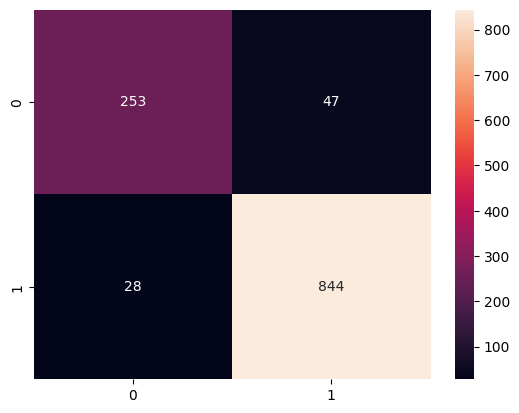

In [17]:
cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### Affichage des différents params disponibles sur le modèle KNN

In [15]:
model.get_params()

{'memory': None,
 'steps': [('resizeimagetransformer',
   <__main__.ResizeImageTransformer at 0x20e1795f380>),
  ('flattentransformer', <__main__.FlattenTransformer at 0x20e17f1ede0>),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'resizeimagetransformer': <__main__.ResizeImageTransformer at 0x20e1795f380>,
 'flattentransformer': <__main__.FlattenTransformer at 0x20e17f1ede0>,
 'kneighborsclassifier': KNeighborsClassifier(),
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

#### GridSearchCV pour le Recall Score -> Recherche du best paramètre pour kneighborsclassifier__n_neighbors

In [24]:
param_grid = {
    'kneighborsclassifier__n_neighbors': np.arange(1, 101, 2)
    # 'kneighborsclassifier__weights': ['uniform', 'distance'],
    # 'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [20]:
model_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=4, scoring=make_scorer(recall_score, pos_label="PNEUMONIA"))
use_all_dataset()
model_grid_search.fit(datasetX, datasetY)
model_grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 49}

recall :  0.9885321100917431
precision :  0.8969823100936525
f1score :  0.9405346426623022


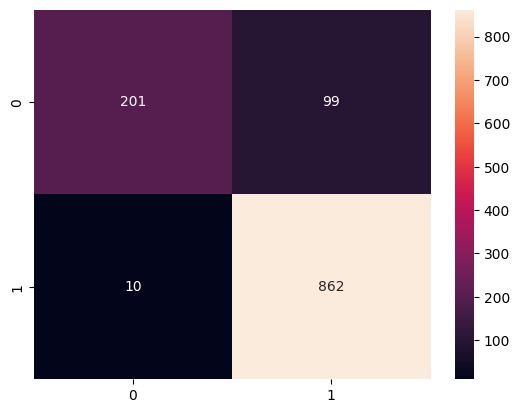

In [21]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### GridSearchCV pour le Precision Score -> Recherche du best paramètre pour kneighborsclassifier__n_neighbors TO DO

In [ ]:
model_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=4, scoring=make_scorer(precision_score, pos_label="PNEUMONIA"))
use_all_dataset()
model_grid_search.fit(datasetX, datasetY)
model_grid_search.best_params_

In [ ]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### GridSearchCV pour le F1 Score -> Recherche du best paramètre pour kneighborsclassifier__n_neighbors

In [25]:
model_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=4, scoring=make_scorer(f1_score, pos_label="PNEUMONIA"))
use_all_dataset()
model_grid_search.fit(datasetX, datasetY)
model_grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 11}

recall :  0.9896788990825688
precision :  0.9180851063829787
f1score :  0.9525386313465783


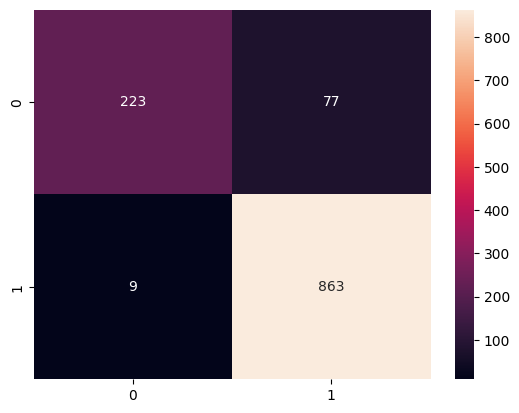

In [26]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [ ]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [ ]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=5)
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

#### GridSearchCV pour le F1 Score -> Recherche du best paramètre pour kneighborsclassifier__weights

In [28]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=11)
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

,all,ratio,black_pixel,ratio_black_pixel
test_recall,"[0.9836257309941521, 0.9836065573770492, 0.981...","[0.969335604770017, 0.9641638225255973, 0.9641...","[0.9576719576719577, 0.9603174603174603, 0.962...","[0.9140625, 0.90625, 0.9140625, 0.8671875, 0.9..."
train_recall,"[0.9888823873610298, 0.9880081895291021, 0.986...","[0.9752665245202559, 0.9782608695652174, 0.973...","[0.971523178807947, 0.9688741721854305, 0.9635...","[0.9208984375, 0.9345703125, 0.923828125, 0.92..."
test_precision,"[0.908207343412527, 0.9180327868852459, 0.9178...","[0.9104, 0.9216965742251223, 0.911290322580645...","[0.8743961352657005, 0.8832116788321168, 0.926...","[0.9105058365758755, 0.90625, 0.92490118577075..."
train_precision,"[0.9154929577464789, 0.9164405860010851, 0.913...","[0.9100676482292082, 0.9143426294820717, 0.916...","[0.8758208955223881, 0.875, 0.886654478976234,...","[0.890462700661001, 0.8994360902255639, 0.9087..."
test_f1,"[0.9444132509825941, 0.9496890898812889, 0.948...","[0.9389438943894389, 0.9424520433694745, 0.936...","[0.9141414141414141, 0.9201520912547528, 0.944...","[0.9122807017543859, 0.90625, 0.91944990176817..."
train_f1,"[0.9507735583684951, 0.9508796622097114, 0.948...","[0.9415397282832442, 0.9452224052718287, 0.944...","[0.921193092621664, 0.9195474544311754, 0.9235...","[0.9054248679788767, 0.9166666666666666, 0.916..."


In [1]:
param_grid = {
    'kneighborsclassifier__weights': ['uniform', 'distance']
    # 'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [2]:
model_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=4, scoring=make_scorer(f1_score, pos_label="PNEUMONIA"))
use_all_dataset()
model_grid_search.fit(datasetX, datasetY)
model_grid_search.best_params_

NameError: name 'GridSearchCV' is not defined

recall :  0.9896788990825688
precision :  0.9180851063829787
f1score :  0.9525386313465783


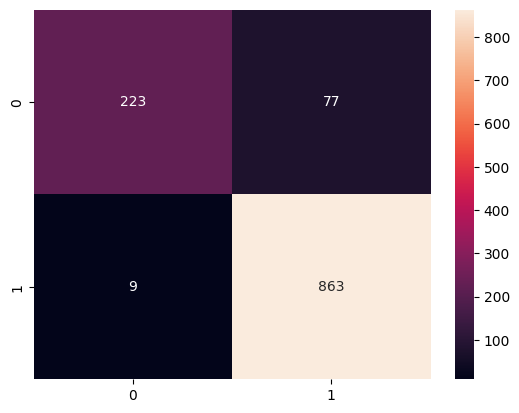

In [31]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### GridSearchCV pour le F1 Score -> Recherche du best paramètre pour kneighborsclassifier__algorithm et kneighborsclassifier__weights

In [13]:
param_grid = {
    # 'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [14]:
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

logging.info('Starting grid search')

model_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=4,
    scoring=make_scorer(f1_score, pos_label="PNEUMONIA"),
    verbose=3)
logging.info('Loading dataset')
use_all_dataset()
logging.info('Starting fitting process')
model_grid_search.fit(datasetX, datasetY)
logging.info('Grid search completed. Best parameters:')
model_grid_search.best_params_

2024-05-29 11:48:51,665 - INFO - Starting grid search
2024-05-29 11:48:51,666 - INFO - Loading dataset
2024-05-29 11:48:52,643 - INFO - Starting fitting process


Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END kneighborsclassifier__algorithm=auto;, score=0.943 total time=   3.8s
[CV 2/4] END kneighborsclassifier__algorithm=auto;, score=0.961 total time=   4.3s
[CV 3/4] END kneighborsclassifier__algorithm=auto;, score=0.953 total time=   4.5s
[CV 4/4] END kneighborsclassifier__algorithm=auto;, score=0.901 total time=   4.3s
[CV 1/4] END kneighborsclassifier__algorithm=ball_tree;, score=0.943 total time= 5.4min
[CV 2/4] END kneighborsclassifier__algorithm=ball_tree;, score=0.961 total time= 5.4min
[CV 3/4] END kneighborsclassifier__algorithm=ball_tree;, score=0.953 total time= 5.5min
[CV 4/4] END kneighborsclassifier__algorithm=ball_tree;, score=0.901 total time= 5.5min
[CV 1/4] END kneighborsclassifier__algorithm=kd_tree;, score=0.943 total time=108.9min
[CV 2/4] END kneighborsclassifier__algorithm=kd_tree;, score=0.961 total time= 7.7min
[CV 3/4] END kneighborsclassifier__algorithm=kd_tree;, score=0.953 total time= 9.1m

2024-05-29 14:25:40,580 - INFO - Grid search completed. Best parameters:


{'kneighborsclassifier__algorithm': 'auto'}

recall :  0.9896788990825688
precision :  0.9180851063829787
f1score :  0.9525386313465783


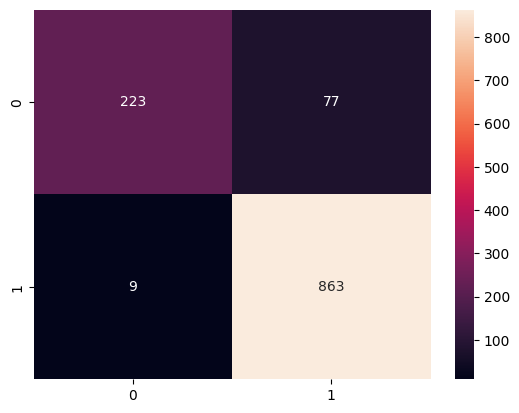

In [15]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### GridSearchCV pour le F1 Score -> Recherche du best paramètre pour kneighborsclassifier__n_neighbors, kneighborsclassifier__algorithm et kneighborsclassifier__weights TO DO

In [13]:
param_grid = {
    'kneighborsclassifier__n_neighbors': np.arange(1, 51, 5),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [14]:
model_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=3, scoring=make_scorer(f1_score, pos_label="PNEUMONIA")) # precision
use_all_dataset()
model_grid_search.fit(datasetX, datasetY)
model_grid_search.best_params_

In [ ]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### KNeighborsClassifier avec les 3 meilleurs paramètres identifiés par GridSearchCV TO DO

In [ ]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto') #11
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

In [ ]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
model.fit(trainx, trainy)

y_pred = model.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()